In [1]:
import torch
import numpy as np
import scanpy as sc
import pandas as pd
#import pybedtools
import matplotlib.pyplot as plt

import matplotlib.colors as clt

import warnings
warnings.filterwarnings("ignore")


In [2]:
def read_samples (t, path, burnin_samples):
    
    theta = torch.load(str(path)+"/theta_"+str(t)+".txt",map_location=torch.device('cpu'))
    m_theta = theta[burnin_samples:,:,:].mean(axis=0)
    m_theta = m_theta/m_theta.sum(axis=1)[:,np.newaxis] 
    
    lam = torch.load(str(path)+"/lam_"+str(t)+".txt",map_location=torch.device('cpu'))
    m_lam = lam[burnin_samples:,:,:].mean(axis=0)
    
    phi = torch.load(str(path)+"phi_"+str(t)+".txt",map_location=torch.device('cpu'))
    m_phi = phi[burnin_samples:,:,:].mean(axis=0)

    
    
    return m_theta, m_lam, m_phi

In [3]:
def read_samples_STS (t, path, burnin_samples):
    
    m_theta, m_lam, m_phi = read_samples (t, path, burnin_samples)
    
    m_lam_ = m_lam/m_lam.sum(axis=0)
    m_phi_ = m_phi/m_phi.sum(axis=0)
    
    return m_theta, m_lam_, m_phi_

In [4]:
def share_topic_output(sc_data,t,path, burnin_samples=50):
    
  m_theta, m_lam, m_phi = read_samples (t, path, burnin_samples)


  sc_data.obsm["SHARE_Topic"]=m_theta.numpy()
  sc.pp.neighbors(sc_data, use_rep="SHARE_Topic")
  sc.tl.umap(sc_data)
    
  return sc_data, m_theta, m_lam, m_phi

In [5]:
def cell_types_visualization (sc_data, key=None):
    
    sc.pl.umap(sc_data,color=key,title=" ",return_fig=True, legend_fontweight='bold')
    
    

In [6]:
def topic_cell_visualization(sc_data, topics, theta, nrows, ncols, figsize):

    
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=figsize)
    cmap = clt.LinearSegmentedColormap.from_list("wr", ("white", "red"))
    vmin, vmax = theta.min(), theta.max()
    i=0
    for c_, ax in enumerate(axes.flat):
      ax.set_title("topic"+str(topics[i]))
      im=ax.scatter(
      x=sc_data.obsm["X_umap"][:,0],
      y=sc_data.obsm["X_umap"][:,1],
      c=theta[:,topics[i]-1],
      cmap=cmap,
      vmin=vmin, vmax=vmax,
      s=0.1)
      i+=1 
      if i==len(topics):
            
            break
    fig.colorbar(im, ax=axes.ravel().tolist())
    

In [15]:
def plot_STS_gene(gene_name,STS_score, distance, df_gene_regions_all_topic,save_fig):
        
        plt.scatter(x=distance-df_gene_regions_all_topic["gene_start"].iloc[1],y=STS_score)
        plt.axvline(x=0, ymin=0, ymax=10,color='green', linestyle='dotted')
        plt.axvline(x=df_gene_regions_all_topic["gene_end"].iloc[n]-df_gene_regions_all_topic["gene_start"].iloc[n]
             , ymin=0, ymax=10,color='red', linestyle='dotted')
        plt.ylabel("$P_g^r$")
        plt.xlabel("d")
        plt.title(gene_name)
        if save_fig:
            plt.savefig('STS_scores_'+str(gene_name)+'.png',bbox_inches='tight',dpi=1000)
        plt.show()
        

In [22]:

def compute_gene_STS (gene_name,t,path, bed_file, burnin_samples = 50,
                      norm_to_max = True, plot = True, save_fig = False): ########Specify the burnin samples(default is 50)
    
    
    df_genes_regions=pd.read_csv(bed_file,delimiter="\t")
    m_theta, m_lam, m_phi = read_samples_STS (t, path, burnin_samples)
   

    gene_num=df_genes_regions["gene_number"][df_genes_regions["gene_name"]==gene_name].iloc[0]
    p_phi = 0
    df_gene_regions_all_topic = df_genes_regions[df_genes_regions["gene_name"]==gene_name]
    i = 0
    num_regions = df_genes_regions[df_genes_regions["gene_name"]==gene_name]["region_number"].shape[0]
    corr = np.zeros(num_regions)
    distance = np.zeros(num_regions)
    distance_end = np.zeros(num_regions)
    
    for n in np.arange(0,num_regions):
        region_num = df_gene_regions_all_topic["region_number"].iloc[n]
 
        p_phi = torch.multiply(m_phi[:,region_num],m_theta)
    
        corr[i] = torch.multiply(p_phi,m_lam[:,gene_num]).sum(axis=0).sum(axis=0).numpy()
        distance[i] = df_gene_regions_all_topic["start_region"].iloc[n]
        i+=1
        
    STS_score = corr/m_theta.shape[0]
    
    if plot:
        
        plot_STS_gene(gene_name, STS_score, distance, df_gene_regions_all_topic,save_fig)
    
    
    if norm_to_max:
        
         return STS_score/STS_score.max(),distance,df_gene_regions_all_topic
    else:

         return STS_score,distance,df_gene_regions_all_topic


In [24]:
def plot_STS (STS_list, distance_list, gene_pos,save_fig):
        max_STS = max(max(inner_list) for inner_list in STS_list)
        plt.figure(figsize = (5,3))
        for i,j in enumerate(gene_pos[:len(distance_list)]):
            plt.scatter(x=distance_list[i]*(-1), y=STS_list[i]/max_STS, alpha=0.3, c='#1f77b4')
        plt.ylabel("$P_g^r$")
        plt.xlabel("d")
        if save_fig:
            plt.savefig('STS_scores.png',bbox_inches='tight',dpi=1000)
        plt.show()
        
        

In [25]:
def compute_STS(t, path, bed_file,  burnin_samples = 50, plot = True, save_fig = False):
    
    df_genes_regions = pd.read_csv(bed_file,delimiter="\t")
    
    m_theta, m_lam, m_phi = read_samples_STS (t, path, burnin_samples)

    gene_list = list(df_genes_regions["gene_name"].drop_duplicates())
    distance_list = []
    STS_list = []
    gene_pos = np.zeros(len(gene_list))
    
    for l,gene in enumerate(gene_list):
        if df_genes_regions[df_genes_regions["gene_name"]==gene].shape[0] != 0:
            gene_num = df_genes_regions["gene_number"][df_genes_regions["gene_name"]==gene].iloc[0]
            x = df_genes_regions["gene_name"]==gene
            num_regions = df_genes_regions[x]["region_number"].shape[0]
            regions_num = df_genes_regions[x]["region_number"].values
            regions_begin = df_genes_regions[x]["start_region"].values
            distance_begin = df_genes_regions[x]["gene_start"]
            p_phi = m_phi[:,regions_num]
            p_phi = torch.multiply(m_theta[:,:,None],p_phi[None,:,:])
            corr = torch.multiply(p_phi,m_lam[:,gene_num][None,:,None]).sum(axis=0).sum(axis=0)
            STS_list.append(corr)
            gene_pos[l] = distance_begin.iloc[0]
            distance_list.append(distance_begin-regions_begin)
    if plot:
        print("ploting..")
        plot_STS(STS_list, distance_list, gene_pos,save_fig)
    
        
    return gene_list, STS_list, distance_list

In [7]:
rna =sc.read_h5ad('/data/nelkazwi/share-topic/lymphoma_data/rna_B_lympho.h5ad')
path = "/scratch/nelkazwi/lymphoma_data/45_topics/"
n_topics = 45
rna, m_theta, m_lam, m_phi = share_topic_output(rna, n_topics, path, burnin_samples=50)

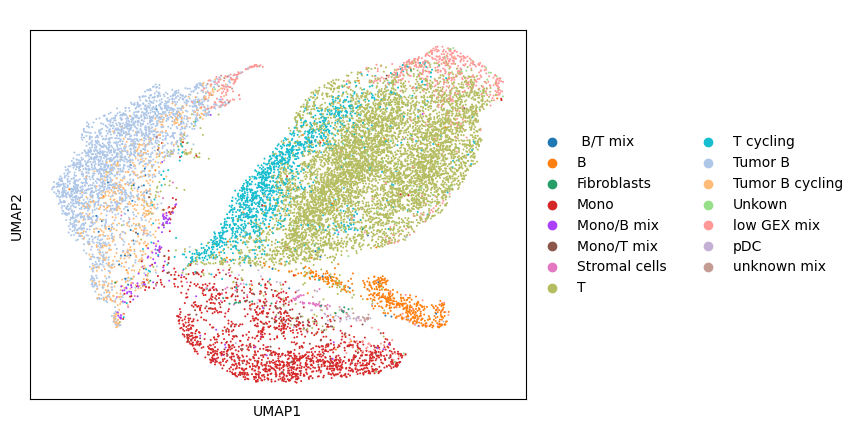

In [9]:
cell_types_visualization(rna, key="cell_types")

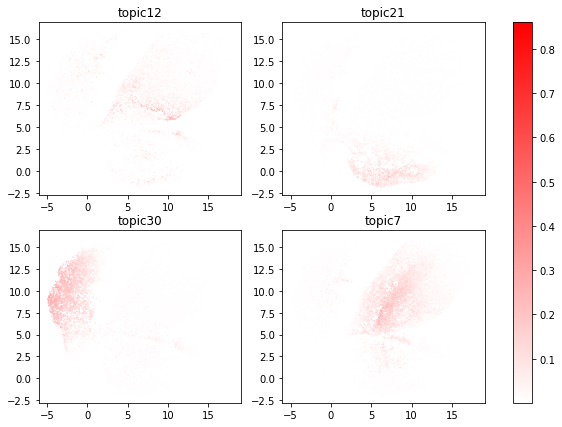

In [10]:
topics = [12,21,30,7]
topic_cell_visualization(rna,topics, m_theta,nrows=2,ncols=2,figsize=(10,7))

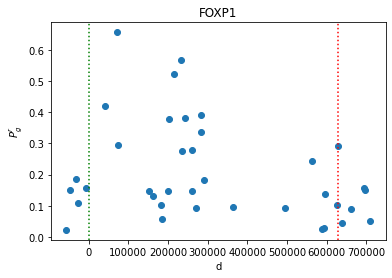

In [23]:

gene_name ="FOXP1"
bed_file = "genes_regions.bed"
STS_score_gene, distance, df_gene_regions_all_topic = compute_gene_STS(gene_name,n_topics, path, bed_file, save_fig = True)

ploting..


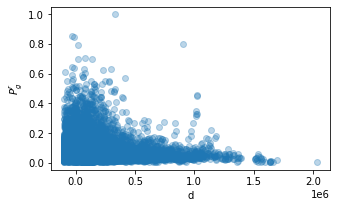

In [26]:
gene_list, STS_list, distance_list = compute_STS(n_topics, path = path, bed_file = bed_file)